In [41]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from operator import add
from dotenv import load_dotenv

load_dotenv()

True

In [42]:
model = ChatOpenAI(model="gpt-4o-mini")

In [43]:
# structured output

class FeedbackModel(BaseModel):

    feedback: Annotated[str, Field(description="Detailed feedback of the item.")]
    score: Annotated[int, Field(ge=0, le=10, description="Score in range between 1-10(including)")]

In [44]:
structured_model = model.with_structured_output(FeedbackModel)

In [45]:
# state

class ReviewState(TypedDict):

    item: str
    camera_review: str
    battery_review: str
    display_review: str
    final_review: str
    individual_scores: Annotated[list[int], add]
    avg_score: float

In [46]:
def generate_camera_review(state: ReviewState):

    item = state["item"]
    prompt = f"Generate a random review of Camera of {item}."
    result = structured_model.invoke(prompt)

    return {"camera_review": result.feedback,
            "individual_scores": [result.score]}

In [47]:
def generate_battery_review(state: ReviewState):

    item = state["item"]
    prompt = f"Generate a random review of Battery of {item}."
    result = structured_model.invoke(prompt)

    return {"battery_review": result.feedback,
            "individual_scores": [result.score]}

In [48]:
def generate_display_review(state: ReviewState):

    item = state["item"]
    prompt = f"Generate a random review of Display of {item}."
    result = structured_model.invoke(prompt)

    return {"display_review": result.feedback,
            "individual_scores": [result.score]}

In [49]:
def generate_final_review(state: ReviewState):

    item = state["item"]
    camera_review = state["camera_review"]
    battery_review = state["battery_review"]
    display_review = state["battery_review"]
    individual_scores = state["individual_scores"]

    prompt = f"Generate a final review of {item} based on below reviews of its camera, battery and display\n\
                Camera Review: {camera_review}\n\
                Battery Review: {battery_review}\n\
                Display Review: {display_review}"
    
    result = model.invoke(prompt).content

    avg_score = sum(individual_scores)/len(individual_scores)

    return {"final_review": result,
            "avg_score": avg_score}

In [50]:
# graph
graph = StateGraph(ReviewState)

# nodes
graph.add_node("generate_camera_review", generate_camera_review)
graph.add_node("generate_battery_review", generate_battery_review)
graph.add_node("generate_display_review", generate_display_review)
graph.add_node("generate_final_review", generate_final_review)

# edges
graph.add_edge(START, "generate_camera_review")
graph.add_edge(START, "generate_battery_review")
graph.add_edge(START, "generate_display_review")

graph.add_edge("generate_camera_review", "generate_final_review")
graph.add_edge("generate_battery_review", "generate_final_review")
graph.add_edge("generate_display_review", "generate_final_review")

graph.add_edge("generate_final_review", END)

workflow = graph.compile()

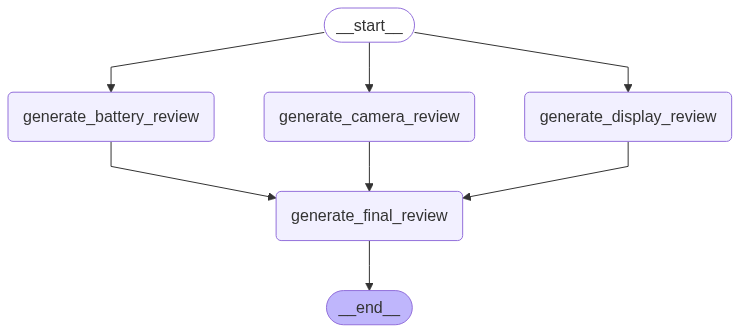

In [51]:
workflow

In [52]:
initial_state = {"item": "Galaxy S25 Ultra"}
final_state = workflow.invoke(initial_state)

In [53]:
final_state

{'item': 'Galaxy S25 Ultra',
 'camera_review': 'The camera on the Galaxy S25 Ultra is nothing short of spectacular. With its impressive 200MP main sensor, every shot taken is incredibly detailed, capturing both vibrant colors and subtle textures. Low-light performance is also top-notch, thanks to the advanced night mode that brightens up dark scenes without introducing too much noise. The zoom capabilities are particularly mind-blowing—up to 100x digital zoom allows for amazing close-ups from a distance, though the quality does drop a little at the highest settings. Additionally, the different shooting modes, including portrait and pro mode, provide users with great flexibility, making it suitable for casual shooters and photography enthusiasts alike. Overall, the camera experience on the Galaxy S25 Ultra truly elevates mobile photography to new heights, making it one of the best on the market.',
 'battery_review': "The Galaxy S25 Ultra's battery life is nothing short of impressive. Wi